# Basic Hydro Example

This example uses most of the same code as the basic_example but adds the hydro unit with a monthly expected generation pulled from the RectifHyd dataset. 

RectifHyd: https://hydrosource.ornl.gov/data/datasets/rectifhydplus/

In [1]:
import sys
import os

assetra_path = r'C:\Users\mlchris\OneDrive - Umich\Desktop\assetra_edits'
sys.path.insert(0, assetra_path)

In [2]:
from datetime import datetime 
import xarray as xr

#declare values and create hourly timeseries function  


HOURS_PER_YEAR = 8760 # h

HOURLY_DEMAND = 10 # MW
STOCHASTIC_NUM_UNITS = 12
STOCHASTIC_UNIT_NAMEPLATE_CAPACITY = 1 # MW
STOCHASTIC_UNIT_FORCED_OUTAGE_RATE = 0.05
STORAGE_NUM_UNITS = 10
STORAGE_UNIT_NAMEPLATE_CAPACITY = 1 # MW
STORAGE_UNIT_ENERGY_CAPACITY = 1 # MWh
STORAGE_UNIT_EFFICIENCY = 0.8
HYDRO_UNIT_FORCED_OUTAGE_RATE = 0.25
SIMULATION_START_HOUR = "2019-01-01 00:00:00"
SIMULATION_END_HOUR = "2019-12-31 23:00:00"
SIMULATION_TRIAL_SIZE = 100

def get_hourly_time_series_xr(
    hourly_data: list[float], 
    start_hour: datetime="2019-01-01 00:00:00"
) -> xr.DataArray:
    '''Return formatted xarray data array for a sequence of hourly datapoints

    Args:
        hourly_data (list[float]): Input data stored as consecutive hour-scale datapoints.
        start_hour (_type_, optional): Time stamp corresponding to the first datapoint.
            Defaults to "2016-01-01 00:00:00".

    Returns:
        xr.Dataarray: Formatted one-dimensional xarray data with datetime-indexed time series.
    '''
    return xr.DataArray(
        data=[float(x) for x in hourly_data],
        coords=dict(
            time=xr.date_range(start_hour, freq='1H', periods=len(hourly_data))
        )
    )


Builder for stoachastic and storage units, identical to basic_example 

In [3]:
from assetra.system import EnergySystemBuilder
from assetra.units import DemandUnit, StochasticUnit, StorageUnit, HydroUnit

builder = EnergySystemBuilder()

# add demand (constant 100 MW for one year)
new_unit = DemandUnit(
    id=0,
    hourly_demand=get_hourly_time_series_xr([HOURLY_DEMAND]*HOURS_PER_YEAR)
)
builder.add_unit(new_unit)

# add 100 (1 MW) stochastic units
for _ in range(STOCHASTIC_NUM_UNITS):
    new_unit = StochasticUnit(
        id=builder.size,
        nameplate_capacity=STOCHASTIC_UNIT_NAMEPLATE_CAPACITY,
        hourly_capacity=get_hourly_time_series_xr([STOCHASTIC_UNIT_NAMEPLATE_CAPACITY]*HOURS_PER_YEAR),
        hourly_forced_outage_rate=get_hourly_time_series_xr([STOCHASTIC_UNIT_FORCED_OUTAGE_RATE]*HOURS_PER_YEAR)
    )
    builder.add_unit(new_unit)

# add 10 (1 MW, 1 Hour) storage units
for _ in range(STORAGE_NUM_UNITS):
    new_unit = StorageUnit(
        id=builder.size,
        nameplate_capacity=STORAGE_UNIT_NAMEPLATE_CAPACITY,
        charge_rate=STORAGE_UNIT_NAMEPLATE_CAPACITY,
        discharge_rate=STORAGE_UNIT_NAMEPLATE_CAPACITY,
        charge_capacity=STORAGE_UNIT_ENERGY_CAPACITY,
        roundtrip_efficiency=STORAGE_UNIT_EFFICIENCY
    )
    builder.add_unit(new_unit)




c:\Users\mlchris\OneDrive - Umich\Desktop\assetra_edits\env\Lib\site-packages\xarray\coding\cftime_offsets.py:1434: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(
c:\Users\mlchris\OneDrive - Umich\Desktop\assetra_edits\env\Lib\site-packages\xarray\coding\cftime_offsets.py:1434: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(


**Add the Hydro Unit**

Now we add in the hydro unit, first reading in the months expected generation from a CSV and reformatting it into an xarray then adding the unit to the builder.

In [4]:
import pandas as pd
#function to read in the hydro data from the CSV
def Hydro_ReadIn(): 
    #read in hydro predictions
    hydro_predictions_df = pd.read_csv('hydro_example_monthly_gen.csv').set_index('date')
    # Ensure the date column is a datetime object
    hydro_predictions_df.index = pd.to_datetime(hydro_predictions_df.index)
    # Convert the DataFrame to an xarray DataArray
    monthly_expected_generation_xr = hydro_predictions_df.to_xarray()
    # Extract month and year from the date index
    monthly_expected_generation_xr['month'] = ('time', monthly_expected_generation_xr['date.month'].data)
    monthly_expected_generation_xr['year'] = ('time', monthly_expected_generation_xr['date.year'].data)
    # Reshape for multi-dimensional indexing
    monthly_expected_generation_xr = monthly_expected_generation_xr.rename({'date': 'time'})
    return monthly_expected_generation_xr

monthly_generation = Hydro_ReadIn()

#add the new hydro unit to builder 
new_unit = HydroUnit(
    id = builder.size,
    nameplate_capacity = 1.3, #in MW
    monthly_expected_generation = monthly_generation['hydro_unit 34'],
    hourly_forced_outage_rate = get_hourly_time_series_xr([HYDRO_UNIT_FORCED_OUTAGE_RATE]*HOURS_PER_YEAR)
)
builder.add_unit(new_unit)

c:\Users\mlchris\OneDrive - Umich\Desktop\assetra_edits\env\Lib\site-packages\xarray\coding\cftime_offsets.py:1434: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(


We compile our energy system using `builder.build()`, same as in basic_example.

In [5]:
energy_system = builder.build()

Save or load energy system and run simualtion. If you look at the energy system folder you will see HydroUnit.assetra.nc along with the other unit files. If using a forced outage rate on the Hydro Unit, the simulation will likely take longer to run.

In [6]:
from assetra.system import EnergySystem
from pathlib import Path

saved_system_dir = Path('saved_energy_system')

if not saved_system_dir.exists():
    # save energy system 
    energy_system.save(saved_system_dir)
else:
    energy_system = EnergySystem()
    energy_system.load(saved_system_dir)


In [7]:
from assetra.simulation import ProbabilisticSimulation

simulation = ProbabilisticSimulation(
    SIMULATION_START_HOUR,
    SIMULATION_END_HOUR,
    SIMULATION_TRIAL_SIZE
)
simulation.assign_energy_system(energy_system)
simulation.run()

In [8]:
simulation._net_hourly_capacity_matrix

<xarray.DataArray (trial: 100, time: 8760)> Size: 7MB
array([[2.3771828, 1.3771828, 0.       , ..., 1.3918297, 2.3918297,
        2.3918297],
       [0.3771828, 0.3771828, 1.3771828, ..., 2.3918297, 2.3918297,
        1.3918297],
       [1.3771828, 1.3771828, 2.3771828, ..., 1.3918297, 2.3918297,
        2.3918297],
       ...,
       [2.3771828, 1.3771828, 1.3771828, ..., 1.3918297, 2.3918297,
        1.3918297],
       [2.3771828, 2.3771828, 2.3771828, ..., 1.3918297, 1.3918297,
        0.3918297],
       [1.3771828, 2.3771828, 2.3771828, ..., 2.3918297, 1.3918297,
        2.3918297]], shape=(100, 8760))
Coordinates:
  * trial    (trial) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * time     (time) datetime64[ns] 70kB 2019-01-01 ... 2019-12-31T23:00:00

**Graph the Hydro Unit Behavior**

See graph below, hydro unit hourly is based on the total generation for the month and then distributed hourly based on net demand. Here every hour of the month is similar because demand is constant.

Text(0, 0.5, 'Hourly Hydro Output (MW)')

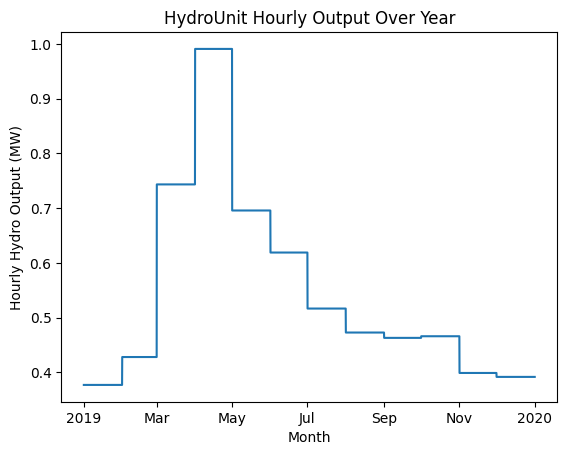

In [9]:
import matplotlib.pyplot as plt
simulation._hourly_capacity_matrix.isel(unit_type =2, trial = 0).plot()
plt.title('HydroUnit Hourly Output Over Year')
plt.xlabel('Month')
plt.ylabel('Hourly Hydro Output (MW)')

Finally, we evaluate the resource adequacy of our system, in this case loss of load hours.

In [10]:
from assetra.metrics import LossOfLoadHours

lolh_model = LossOfLoadHours(simulation)
lolh = lolh_model.evaluate()

print("System LOLH:", lolh)

System LOLH: 0.0


The purpose of this example is only to show basic inetgration of the HydroUnit in the `assetra` package.